# Курсовая работа

---
## по теме: "Построение рекомендательной системы в области закупок с помощью графовых нейронных сетей"

Выполнила: студентка учебной группы\
ПМ21-1\
Стаханова Анастасия Андреевна


# 1. Импорт библиотек

In [609]:
#!pip install pymorphy2
#!pip install torch==2.1.2
#!pip install DGL==2.1.0

In [168]:
import pandas as pd
import numpy as np
import random
import re
import string
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from numba import jit
import time

import pymorphy2
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import scipy.sparse as sp
import itertools

import dgl
import dgl.function as fn
from dgl.nn import SAGEConv, GraphConv, GATConv

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, classification_report

nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2. Загрузка датасета

In [5]:
df = pd.read_excel('/content/ContractSearch(1-5000)_06.05.2024 (4).xlsx')
df.head()

,Номер реестровой записи контракта,Заказчик: наименование,Заказчик: ИНН,Предмет контракта,"Объект закупки: наименование товаров, работ, услуг",Цена контракта,Объект закупки: код позиции,"Объект закупки: сумма, рублей","Информация о поставщиках (исполнителях, подрядчиках) по контракту: наименование юридического лица (ф.и.о. физического лица)","Информация о поставщиках (исполнителях, подрядчиках) по контракту: ИНН"
0,'3183504891023000030',МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,'1835048910','№ 32787 Хлебобулочные изделия для нужд учрежд...,Хлеб недлительного хранения,"'252 032,14'",10.71.11.110-00000004,84010.01,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",'5920034144'
1,'3183504891023000030',МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,'1835048910','№ 32787 Хлебобулочные изделия для нужд учрежд...,Хлеб недлительного хранения,"'252 032,14'",10.71.11.110-00000002,84010.02,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",'5920034144'
2,'3183504891023000030',МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,'1835048910','№ 32787 Хлебобулочные изделия для нужд учрежд...,Булочные изделия,"'252 032,14'",10.71.11.120-00000004,84010.03,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",'5920034144'
3,'2781020117024000019',САНКТ-ПЕТЕРБУРГСКОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ...,'7810201170',"'Оказание услуг на отпуск питьевой воды, прием...",Вода питьевая,"'100 740,00'",36.00.11.000,'100740.00',"ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ ""ВОДОКАН...",'7830000426'
4,'2502700146623000079',ГОСУДАРСТВЕННОЕ КАЗЁННОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРА...,'5027001466','Поставка продуктов питания : Поставка хлеба д...,Хлеб ржаной,"'179 550,00'",10.86.10.700,'45600.00',"АКЦИОНЕРНОЕ ОБЩЕСТВО ""ЕГОРЬЕВСКИЙ ХЛЕБОКОМБИНАТ""",'5011017573'


В данном датасете имеются:\
1) Номер контракта (ID) - contract_number\
2) Наименование заказчика - customer_name\
3) ИНН заказчика (который мы будем использовать в качестве ID) - customer_INN\
4) Предмет конракта - contract_predmet\
5) Объекты закупки - contract_elems\
6) Сумма всего контракта (в один конракт могут входить несколько позиций или же несколько закупок) - contract_price\
7) Специальный код закупки - order_code\
8) Сумма закупки - order_price\
9) Наименование поставщика - provider_name\
10) ИНН поставщика (который мы будем использовать в качестве ID) - provider_INN

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29832 entries, 0 to 29831
Data columns (total 10 columns):
 #   Column                                                                                                                       Non-Null Count  Dtype 
---  ------                                                                                                                       --------------  ----- 
 0   Номер реестровой записи контракта                                                                                            29832 non-null  object
 1   Заказчик: наименование                                                                                                       29832 non-null  object
 2   Заказчик: ИНН                                                                                                                29832 non-null  object
 3   Предмет контракта                                                                                                        

In [7]:
print('Длина датасета = ', len(df))
print('Количество столбцов = ', len(df.columns))

Длина датасета =  29832
Количество столбцов =  10


Изменение наименований столбцов для удобства

In [8]:
new_names = ['contract_number','customer_name','customer_INN',
             'contract_predmet','contract_elems','contract_price',
             'order_code','order_price','provider_name','provider_INN']
df.columns = new_names

In [9]:
print('Количество пропущенных значений:')
df.isnull().sum()

Количество пропущенных значений:


contract_number      0
customer_name        0
customer_INN         0
contract_predmet    18
contract_elems       0
contract_price       0
order_code           0
order_price          3
provider_name        0
provider_INN         0
dtype: int64

# 3. Преобразования датасета

## 3.1 Работа с типами данных

Функция для преобразования ИНН в число

In [10]:
def work_with_INN(df, column_name):
    df[column_name] = df[column_name].astype(str).str.replace("'", '').apply(lambda x: int(x))
work_with_INN(df, 'customer_INN')
work_with_INN(df, 'provider_INN')

Функция для корректного отображения цены контракта

In [11]:
def convert_price(df, column_name):
    df[column_name] = df[column_name].astype(str).str.replace("'", '').str.replace(",", ".").str.replace(" ", "").apply(lambda x: float(x))
convert_price(df, 'contract_price')

Функция для корректного отображения цены закупки. Также если значение order_price пустое, а contract_price содержит в себе какую-то цену, то функция добавляет информацию о ней в пустующую ячейку в солбец order_price

In [12]:
def process_column(df, column_name, default_column_name):
    for index, value in df[column_name].items():
        if isinstance(value, str):
            value = value.replace("'", "").replace(" ", "").replace(",", ".")
            value = float(value)
            if value == '':
                df.loc[index, column_name] = float(df.loc[index, default_column_name])
            else:
                df.loc[index, column_name] = float(value)
    df[column_name] = df[column_name].apply(lambda x: float(x))
process_column(df, 'order_price', 'contract_price')

## 3.2 Изменение содержания данных

Создание нового столбца 'product', в который войдут contract_elems и contract_predmet

In [13]:
df['product'] = df['contract_elems'] + ' ' + df['contract_predmet']
df = df.drop(['contract_elems', 'contract_predmet'], axis =1)

Убираем колонку 'contract_price', так как она содержит в себе информацию о цене всего контракта, а не конкретно одной закупки

In [14]:
df = df.drop(['contract_price'], axis = 1)

## 3.3 Удаление пропусков и дубликатов

In [15]:
df = df.dropna()
df = df.drop_duplicates()
len(df)

28471

Теперь нам не понадбится колонка 'order_code', так как именно она помогла отследить и удалить дубликаты (ИНН и order_code давали уникальное значение для каждого контракта)

In [16]:
df = df.drop(['order_code'], axis = 1)

## 3.4 Создание уникального кода закупки

Удаленный 'order_code' - это уникальный номер всего контракта, поэтому в некоторых строках он одинаковый, так как в контракте могут быть несколько объектов (закупок). Но нам нужно добиться уникального номера именно для каждой закупки. Поэтому создадим новую колонку с уникальным кодом (ID) для удобства дальнейшей работы.

In [17]:
def add_ID(df):
    random_values = [''.join(random.choices(string.digits, k=15)) for _ in range(len(df))]
    new_column_name = 'ID'
    df[new_column_name] = random_values
    return df

df = add_ID(df)
df = df[['ID'] + [x for x in df.columns if x != 'ID']]
df = df.drop(['contract_number'], axis = 1)
df.head(3)

,ID,customer_name,customer_INN,order_price,provider_name,provider_INN,product
0,411631361384158,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.01,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Хлеб недлительного хранения '№ 32787 Хлебобуло...
1,883972649649580,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.02,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Хлеб недлительного хранения '№ 32787 Хлебобуло...
2,776595161913175,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.03,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Булочные изделия '№ 32787 Хлебобулочные издели...


In [18]:
df['ID'] = df['ID'].apply(lambda x: int(x))

## 3.5 Итоги обработки

In [19]:
df.head(3)

,ID,customer_name,customer_INN,order_price,provider_name,provider_INN,product
0,411631361384158,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.01,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Хлеб недлительного хранения '№ 32787 Хлебобуло...
1,883972649649580,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.02,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Хлеб недлительного хранения '№ 32787 Хлебобуло...
2,776595161913175,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.03,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Булочные изделия '№ 32787 Хлебобулочные издели...


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28471 entries, 0 to 29831
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             28471 non-null  int64  
 1   customer_name  28471 non-null  object 
 2   customer_INN   28471 non-null  int64  
 3   order_price    28471 non-null  float64
 4   provider_name  28471 non-null  object 
 5   provider_INN   28471 non-null  int64  
 6   product        28471 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 1.7+ MB


В итоговом датасете имеются:\
1) Номер закупки - ID\
2) Наименование заказчика - customer_name\
3) ИНН заказчика - customer_INN\
4) Сумма закупки - order_price\
5) Наименование поставщика - provider_name\
6) ИНН поставщика - provider_INN\
7) Содержание закупки (товар/услуга) - product

In [21]:
df.to_csv('all_data.csv', index = False)

# 4. Разделение датасета

## 4.1 Ребра графа (edges)

In [22]:
df = pd.read_csv('/content/all_data.csv')

In [23]:
edges = df[['ID', 'customer_INN', 'provider_INN', 'order_price']]
edges.head(5)

,ID,customer_INN,provider_INN,order_price
0,411631361384158,1835048910,5920034144,84010.01
1,883972649649580,1835048910,5920034144,84010.02
2,776595161913175,1835048910,5920034144,84010.03
3,930479398910246,7810201170,7830000426,100740.00
4,698786687847432,5027001466,5011017573,45600.00


In [24]:
print('Длина датасета = ', len(edges))
print('Количество колонок = ', len(edges.columns))

Длина датасета =  28471
Количество колонок =  4


## 4.2 Вершины графа (nodes)

In [25]:
nod = pd.concat([df['customer_INN'], df['provider_INN']]).unique()
len(nod)

3888

In [26]:
print('Кол-во уникальных ИНН поставщиков -', len(df['provider_INN'].unique()))

Кол-во уникальных ИНН поставщиков - 2026


In [27]:
print('Кол-во уникальных ИНН заказщиков -', len(df['customer_INN'].unique()))

Кол-во уникальных ИНН заказщиков - 1862


Функция, которая выписывает все уникальные ИНН как заказчиков, так и поставщиков и ищет для них всю информацию о продуктав, с которыми они встречались

In [28]:
def extract_product_info(df, nodes):
    unique_prov = list(df['provider_INN'].unique())
    products_info = []
    for node in nodes:
      if node in unique_prov:
        supplier_data = df[df['provider_INN'] == node]

        product_info_list = list(supplier_data['product'].astype(str).unique())
        product_info = ', '.join(product_info_list)

        products_info.append({'INN': node, 'product': product_info})
      else:
        supplier_data = df[df['customer_INN'] == node]

        product_info_list = list(supplier_data['product'].astype(str).unique())
        product_info = ', '.join(product_info_list)
        products_info.append({'INN': node, 'product': product_info})

    new_dataset = pd.DataFrame(products_info)
    new_dataset = new_dataset.sort_values(by='INN').reset_index(drop=True)

    return new_dataset
nodes = extract_product_info(df, nod)
nodes

,INN,product
0,104008357,Филе тресковых рыб мороженое (Филе минтая) 'П...
1,104008396,"Молоко, 2,5%, 1 л 'Поставка продуктов питания..."
2,105003182,"Молоко, 2,5%, 1 л 'Поставка продуктов питания..."
3,105013462,Смесь сушеных фруктов (сухой компот) 'Сухофрук...
4,105019055,Молоко питьевое 'продукты питания (молоко пить...
...,...,...
3883,862199205474,Выполнение работ по текущему ремонту 5-ой груп...
3884,910209932045,Говядина замороженная для детского питания. От...
3885,920100129510,Мясо сельскохозяйственной птицы охлажденное дл...
3886,920355485507,Филе лососевых рыб мороженое. отсутствует 'на ...


In [29]:
print('Длина датасета = ', len(nodes))
print('Количество колонок = ', len(nodes.columns))

Длина датасета =  3888
Количество колонок =  2


## 5. Лемматизация информации и продуктах

In [30]:
morph = pymorphy2.MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

In [31]:
@jit
def preprocess_text_numba(text):
    # Удаление всех символов, кроме букв
  text = re.sub(r'[^А-Яа-я]', ' ', text)
  words = text.lower().split()
    # Удаление стоп-слов
  filtered_words = [w for w in words if w not in stop_words]
    # Лемматизация
  lemmatized_words = [morph.parse(word)[0].normal_form for word in filtered_words]

  return ' '.join(lemmatized_words)

def preprocess_column_numba(df, column_name):
    tqdm.pandas()

    def preprocess_row(row):
        row[column_name] = preprocess_text_numba(row[column_name])
        return row

    updated_df = df.progress_apply(preprocess_row, axis=1)

    return updated_df

dff = preprocess_column_numba(nodes, 'product')
dff.head(3)

100%|██████████| 3888/3888 [02:25<00:00, 26.76it/s]


,INN,product
0,104008357,филе тресковый рыба мороженое филе минтай пост...
1,104008396,молоко л поставка продукт питание молочный про...
2,105003182,молоко л поставка продукт питание молочный про...


Эта функция обрабатывает строки в столбце следующим образом: если в строке менее 6 слов, то добавляются самые часто встречающиеся слова, чтобы длина строки стала равной 6; если слов больше или равно 6, то выбирается топ 6 самых встречающихся. В результате, в каждой строке будет содержаться 6 слов в виде строки.

In [35]:
def process_words_in_column(df, column_name):
    def fill_missing_words(words):
        count = Counter(words)
        while len(words) != 6:
            most_common_word = count.most_common(1)[0][0]
            words.append(most_common_word)
        return ' '.join(words)

    def get_top_words(words):
        count = Counter(words)
        top_words = [word for word, _ in count.most_common(6)]
        return ' '.join(top_words)

    def process_row(row):
        if isinstance(row[column_name], str):
            words = row[column_name].split()
        elif isinstance(row[column_name], list):
            words = row[column_name]
        else:
            words = []

        if len(words) == 0:
          return ''
        elif len(words) > 6:
            return get_top_words(words)
        else:
            return fill_missing_words(words)

    df[column_name] = df.apply(process_row, axis=1)

    return df

In [36]:
processed_df = process_words_in_column(dff, 'product')
processed_df

,INN,product
0,104008357,поставка продукт питание молочный продукция рыба
1,104008396,поставка продукт питание молочный продукция гр
2,105003182,продукт питание поставка молочный продукция мо...
3,105013462,крупа изделие рис горох фасоль печение
4,105019055,молоко питьевой продукт питание молоко питьевой
...,...,...
3883,862199205474,сиверский выполнение работа текущий ремонт ой
3884,910209932045,говядина питание субпродукт заморозить отсутст...
3885,920100129510,куриный питание мясо сельскохозяйственный птиц...
3886,920355485507,рыба филе мороженое отсутствовать поставка про...


In [37]:
for i in processed_df['product']:
  if len(i.split()) < 6 and len(i.split())!=0:
    print(i)
    print('Где-то есть строка не той длины')

In [38]:
nodes_pro = processed_df
nodes_pro = nodes_pro.fillna('')

In [39]:
edges.to_csv('d_edges.csv', index = False)
nodes_pro.to_csv('d_nodes.csv', index = False)

# 6. Векторизация

Свойства графа не могут содержать данные в виде строкового формата, поэтому столбец 'product' должен быть векторизирован.
Для этого использован  TF-IDF (TF-IDF вычисляет числовые представления слов в тексте, учитывая частотность их употребления и уникальность в контексте документов. Используя TF-IDF, можно выделить ключевые слова и фразы, которые наиболее информативно описывают содержание текста
.
Полученные "объекты" векторизируются, так как в качестве свойств графа нельзя использовать данные формата str.
TF-IDF (Term Frequency — Inverse Dense Frequency) - это метод, который помогает определить важность слов в тексте на основе их частотности.

In [40]:
nodes = pd.read_csv('/content/d_nodes.csv')
nodes.head(1)

,INN,product
0,104008357,поставка продукт питание молочный продукция рыба


In [41]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(nodes['product'].values.astype('U').tolist())
nodes_info = torch.tensor(X.toarray())
nodes_info

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [42]:
nodes_info.shape

torch.Size([3888, 2286])

# 5. Создание графа

## 5.1 Подготовка вершин

In [43]:
edges = pd.read_csv('/content/d_edges.csv')
edges.head(1)

,ID,customer_INN,provider_INN,order_price
0,411631361384158,1835048910,5920034144,84010.01


In [44]:
all_inn = sorted(pd.concat([edges['customer_INN'], edges['provider_INN']]).unique().tolist())
counter = {val: i for i, val in enumerate(all_inn)}

In [45]:
customer_inn = [counter[i] for i in edges['customer_INN']]
provider_inn = [counter[i] for i in edges['provider_INN']]
nodes_dict = {'customer_INN':customer_inn,
              'provider_INN': provider_inn}

In [46]:
nodes = pd.DataFrame(nodes_dict)
nodes

,customer_INN,provider_INN
0,420,2024
1,420,2024
2,420,2024
3,3199,3347
4,1831,1819
...,...,...
28466,469,494
28467,563,557
28468,493,581
28469,593,528


In [454]:
nodes.to_csv('Ноды.csv')

## 5.2 Граф

In [548]:
g = dgl.graph((nodes['customer_INN'], nodes['provider_INN']))
g.ndata['products'] = nodes_info
g.edata['order_price'] = torch.tensor(edges['order_price'])

In [549]:
print('Узлы: ', g.nodes())
print('Ребра:', g.edges())
print('Кол-во вершин = ', g.num_nodes())
print('Кол-во рёбер = ', g.num_edges())
print(' ')
print('Ребра (вместе с ID):', g.edges(form='all'))
print('Фичи узлов: ', g.ndata)
print(' ')
print('Входящие степени узлов в графе:', g.in_degrees())
print('Исходящие степени узлов в графе:', g.out_degrees())

Узлы:  tensor([   0,    1,    2,  ..., 3885, 3886, 3887])
Ребра: (tensor([420, 420, 420,  ..., 493, 593, 470]), tensor([2024, 2024, 2024,  ...,  581,  528,  494]))
Кол-во вершин =  3888
Кол-во рёбер =  28471
 
Ребра (вместе с ID): (tensor([420, 420, 420,  ..., 493, 593, 470]), tensor([2024, 2024, 2024,  ...,  581,  528,  494]), tensor([    0,     1,     2,  ..., 28468, 28469, 28470]))
Фичи узлов:  {'products': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)}
 
Входящие степени узлов в графе: tensor([ 0,  0, 13,  ...,  3,  3,  1])
Исходящие степени узлов в графе: tensor([8, 5, 0,  ..., 0, 0, 0])


## 5.3 Визуализация графа

In [49]:
G = dgl.to_networkx(g)

In [50]:
colors_dict = {}
for i in G.nodes():
  if i in nodes['customer_INN'].tolist():
    colors_dict[i] = '#B0C4DE'
  else:
    colors_dict[i] = '#8b41c4'

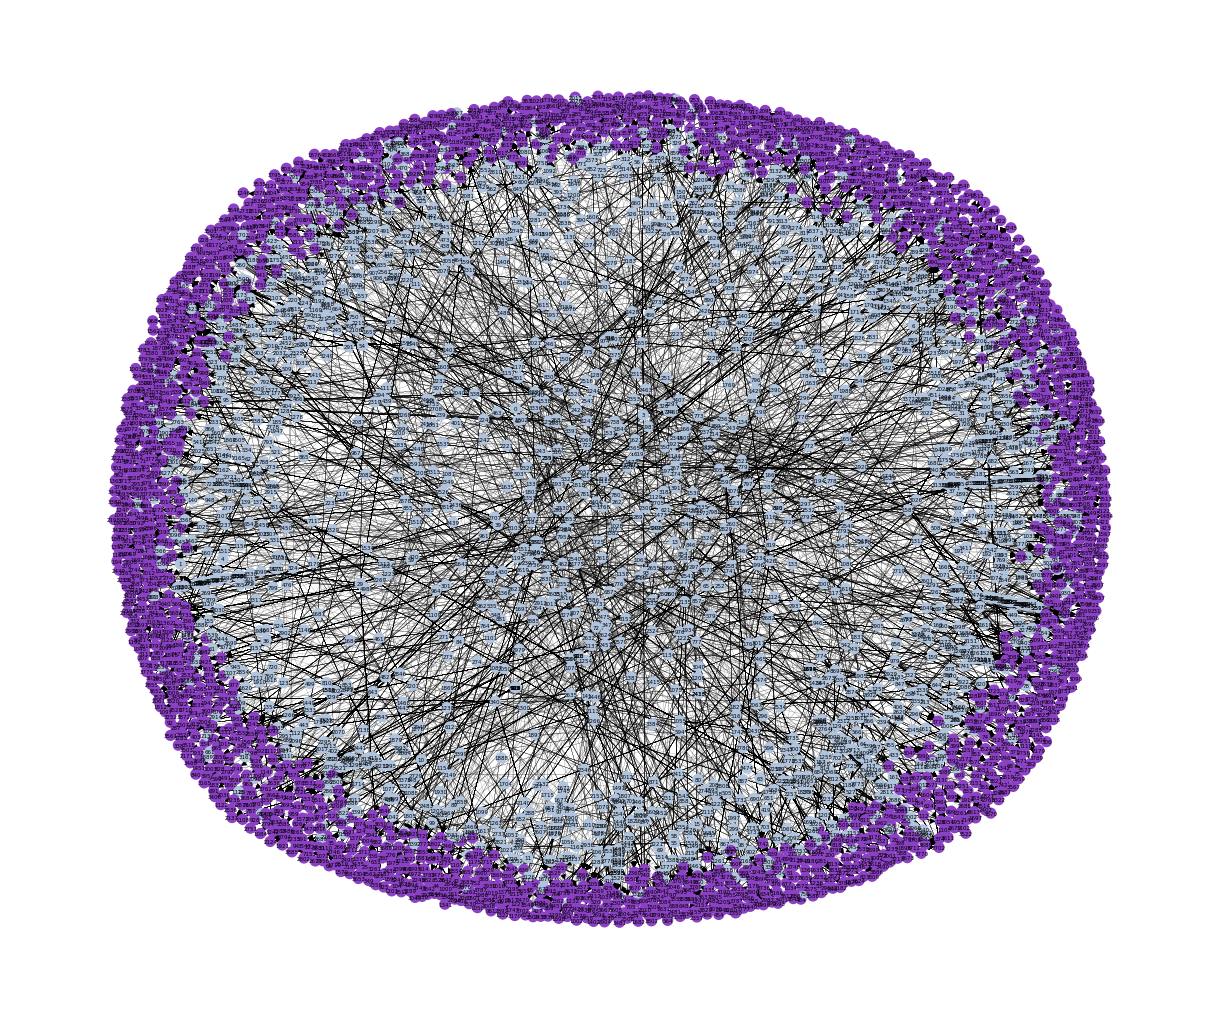

In [51]:
plt.figure(figsize=(12, 10))
nx.draw(G,
        with_labels=True,
        font_size=4,
        node_size=50,
        width=0.1,
        node_color = [colors_dict[node] for node in G.nodes()])
plt.show()

customer_INN - голубой цвет\
provider_INN - фиолетовый цвет

# 6. Разделение на тренировочную и тестовую выборки

In [52]:
def split_graph(g):
    cust, prov = g.edges()
    indices = np.arange(g.num_edges()) # Индексы вершин
    n_nod = g.num_nodes()
    random_indices = np.random.permutation(indices) #рандомный порядок вершин

    test_ratio = 0.1
    test_size = int(len(random_indices) * test_ratio)
    train_size = g.num_edges() - test_size
    print('test_size = ', test_size)
    print('train_size = ', train_size)

    test_pos_cust, test_pos_prov = cust[random_indices[:test_size]], prov[random_indices[:test_size]]
    train_pos_cust, train_pos_prov = cust[random_indices[test_size:]], prov[random_indices[test_size:]]

    # Разреженная матрица смежности (информация о позитивных ребрах)
    adj = sp.coo_matrix((np.ones(len(cust)), (cust.numpy(), prov.numpy())), shape=(n_nod, n_nod))
    # Информация об отсутствующих ребрах (негативных)
    adj_negative = 1 - adj.todense() - np.eye(n_nod)
    negative_cust, negative_prov = np.where(adj_negative != 0)

    negative_random_indices = np.random.choice(len(negative_cust), g.num_edges())
    test_negative_cust, test_negative_prov= negative_cust[negative_random_indices[:test_size]], negative_prov[negative_random_indices[:test_size]]
    train_negative_cust, train_negative_prov = negative_cust[negative_random_indices[test_size:]], negative_prov[negative_random_indices[test_size:]]

    train_g = dgl.remove_edges(g, random_indices[:test_size])
    test_g = dgl.remove_edges(g, random_indices[test_size:])
    train_pos_g = dgl.graph((train_pos_cust, train_pos_prov), num_nodes=n_nod)
    train_negative_g = dgl.graph((train_negative_cust, train_negative_prov), num_nodes=n_nod)
    test_pos_g = dgl.graph((test_pos_cust, test_pos_prov), num_nodes=n_nod)
    test_negative_g = dgl.graph((test_negative_cust, test_negative_prov), num_nodes=n_nod)

    return train_g, train_pos_g, train_negative_g, test_pos_g, test_negative_g, test_g

train_g, train_pos_g, train_negative_g, test_pos_g, test_negative_g, test_g = split_graph(g)

test_size =  2847
train_size =  25624


In [53]:
print("Train Graph:", train_g)
print("Test Graph:", test_g)
print("Train Positive Edges:", train_pos_g.edges())
print("Train Negative Edges:", train_negative_g.edges())
print("Test Positive Edges:", test_pos_g.edges())
print("Test Negative Edges:", test_negative_g.edges())

Train Graph: Graph(num_nodes=3888, num_edges=25624,
      ndata_schemes={'products': Scheme(shape=(2286,), dtype=torch.float64)}
      edata_schemes={'order_price': Scheme(shape=(), dtype=torch.float64)})
Test Graph: Graph(num_nodes=3888, num_edges=2847,
      ndata_schemes={'products': Scheme(shape=(2286,), dtype=torch.float64)}
      edata_schemes={'order_price': Scheme(shape=(), dtype=torch.float64)})
Train Positive Edges: (tensor([ 544, 3029, 3034,  ..., 3029, 3045, 1055]), tensor([ 555, 3553, 2702,  ..., 3553, 3701, 3712]))
Train Negative Edges: (tensor([2191, 1467, 2541,  ...,  116, 3822,  474]), tensor([2518, 2793, 1185,  ..., 2289, 2460, 1122]))
Test Positive Edges: (tensor([3045, 2812,  508,  ..., 1250,  678, 2460]), tensor([3701, 3037,  495,  ...,   83, 3540, 3801]))
Test Negative Edges: (tensor([ 935, 1870,  895,  ..., 3858, 3572, 3050]), tensor([3010, 1445, 1524,  ..., 2084,  995, 1273]))


# 7. Используемые метрики

In [54]:
def compute_loss(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score])
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])
    ])
    # Вычисляем бинарную перекрестную энтропию
    loss = F.binary_cross_entropy_with_logits(scores, labels)
    return loss

In [55]:
def compute_accuracy(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score]).detach().numpy()
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])
    ]).detach().numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return accuracy_score(labels, pred_labels)

In [56]:
def compute_f1(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score]).detach().numpy()
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])]
    ).detach().numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return f1_score(labels, pred_labels)

In [57]:
def compute_auc(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score]).numpy()
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])
    ]).numpy()
    return roc_auc_score(labels, scores)

In [58]:
def compute_conf_matrix(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score]).detach().numpy()
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])
    ]).detach().numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return confusion_matrix(labels, pred_labels)

# 8. DotPredictor

Будем использовать следующий класс для предсказания наличия ребра между двумя узлами.
Этот класс принимает граф и признаки узлов, затем вычисляет скалярные произведения для пар узлов при помощи функции fn.u_dot_v('h', 'h', 'score'), сохраняет результат в атрибуте ребер score.

In [59]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope(): # создает локальную копию данных узлов и ребер графа
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:,0]

# 9. Модели и обучение

## 9.1 GraphSAGE (из библиотеки)

In [322]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hid_feats):
        super(GraphSAGE, self).__init__()
        self.layer1 = SAGEConv(in_feats, hid_feats, 'mean')
        self.layer2 = SAGEConv(hid_feats, hid_feats, 'mean')

    def forward(self, g, features):
        h = self.layer1(g, features)
        h = F.relu(h)
        h = self.layer2(g,h)
        return h

In [323]:
model = GraphSAGE(train_g.ndata["products"].shape[1], 2)
model = model.double()
predictor1 = DotPredictor()
optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), predictor1.parameters()), lr=0.01
)

In [324]:
loss_values, f1_values = [], []
start_time = time.time()
for i in range(250):
    h1 = model(train_g, train_g.ndata["products"])
    positive_score = predictor1(train_pos_g, h1)
    negative_score = predictor1(train_negative_g, h1)
    loss = compute_loss(positive_score, negative_score)
    accuracy = round(compute_accuracy(positive_score, negative_score), 5)
    f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())
    loss = round(loss.item(), 5)
    f1_values.append(f1_sc)

    if i % 10 == 0:
        print(f"In epoch {i}, Loss: {loss}, Accuracy: {accuracy}")
end_time = time.time()
elapsed_time = end_time - start_time


with torch.no_grad():
    positive_score_GD = predictor1(test_pos_g, h1)
    negative_score_GD = predictor1(test_negative_g, h1)
    positive_prob_GD = torch.sigmoid(positive_score_GD)
    negative_prob_GD = torch.sigmoid(negative_score_GD)

def metrics():
  accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
  f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
  auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)
  t = round(elapsed_time, 5)
  return accurary, f1, auc_, t

accurary1, f11, auc_1, t1 = metrics()
print ('Accuracy = :', accurary1)
print ('F1_score = :', f11)
print ('Auc = :', auc_1)
print('Time =', t1)

In epoch 0, Loss: 0.75089, Accuracy: 0.5001
In epoch 10, Loss: 0.64001, Accuracy: 0.65275
In epoch 20, Loss: 0.59142, Accuracy: 0.78838
In epoch 30, Loss: 0.54657, Accuracy: 0.85318
In epoch 40, Loss: 0.50911, Accuracy: 0.85984
In epoch 50, Loss: 0.47929, Accuracy: 0.86639
In epoch 60, Loss: 0.45571, Accuracy: 0.8687
In epoch 70, Loss: 0.43737, Accuracy: 0.87153
In epoch 80, Loss: 0.4231, Accuracy: 0.87246
In epoch 90, Loss: 0.41203, Accuracy: 0.87461
In epoch 100, Loss: 0.40313, Accuracy: 0.87592
In epoch 110, Loss: 0.39602, Accuracy: 0.8783
In epoch 120, Loss: 0.39026, Accuracy: 0.879
In epoch 130, Loss: 0.38541, Accuracy: 0.8808
In epoch 140, Loss: 0.38111, Accuracy: 0.88277
In epoch 150, Loss: 0.37744, Accuracy: 0.88394
In epoch 160, Loss: 0.37421, Accuracy: 0.88472
In epoch 170, Loss: 0.37129, Accuracy: 0.88649
In epoch 180, Loss: 0.36866, Accuracy: 0.88675
In epoch 190, Loss: 0.36631, Accuracy: 0.88729
In epoch 200, Loss: 0.36418, Accuracy: 0.88733
In epoch 210, Loss: 0.36217, Ac

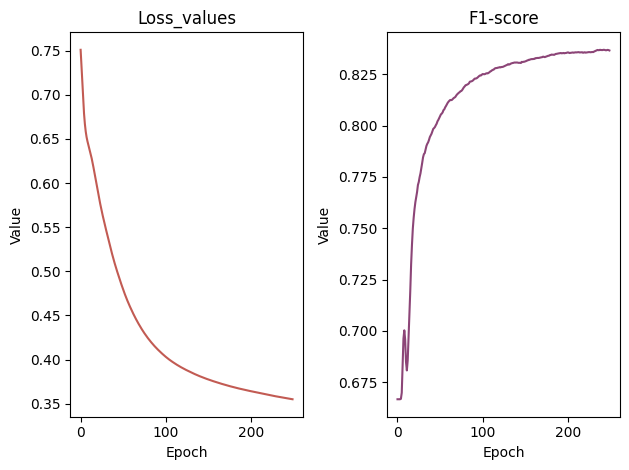

In [326]:
plt.subplot(1, 2, 1)
plt.plot(loss_values, color='#c25b53')
plt.title('Loss_values')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(f1_values, color='#8c4577')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

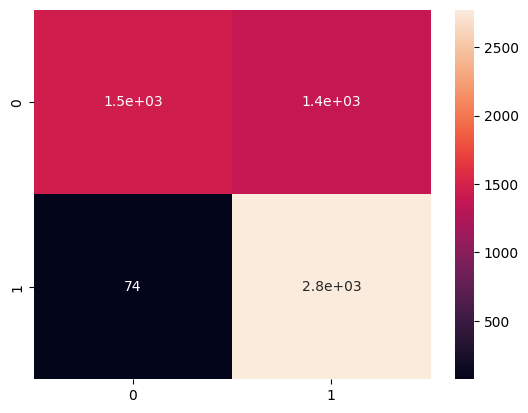

array([[1456, 1391],
       [  74, 2773]])

In [327]:
matrix = compute_conf_matrix(positive_prob_GD, negative_prob_GD)
sns.heatmap(matrix, annot=True)
plt.show()
matrix

TP = 1456: истинно позитивных предсказаний.\
FP = 1391: ложно позитивных предсказаний.\
FN = 74: ложно негативных предсказаний.\
TN = 2773: истинно негативных предсказаний.

Высокое количество TN: Модель правильно классифицирует большинство отрицательных примеров \
Достаточно высокое TP: Модель правильно классифицирует много положительных примеров\
Однако FP тоже высокое: Модель часто классифицирует негативные предсказания как позитивные\
Низкое FN: Модель редко ошибается, классифицируя отрицательные примеры, как положительные

### 9.1.1 Кросс-валидация

In [193]:
kf = KFold(n_splits=5)
loss_values, f1_values = [], []
accuracies, f1_scores, auc_scores = [], [], []
start_time = time.time()

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hid_feats):
        super(GraphSAGE, self).__init__()
        self.layer1 = SAGEConv(in_feats, hid_feats, 'mean')
        self.layer2 = SAGEConv(hid_feats, hid_feats, 'mean')

    def forward(self, g, features):
        h = self.layer1(g, features)
        h = F.relu(h)
        h = self.layer2(g,h)
        return h

for fold, (train_index, val_index) in enumerate(kf.split(train_g.ndata["products"])):
    print(f"Fold {fold+1}")

    # Создание тренировочных и валидационных наборов данных
    train_subset = train_index
    val_subset = val_index

    # Обучение модели
    model = GraphSAGE(train_g.ndata["products"].shape[1], 2).double()
    predictor1 = DotPredictor()
    optimizer = torch.optim.SGD(
        itertools.chain(model.parameters(), predictor1.parameters()), lr=0.3
    )

    for i in range(200):
        model.train()
        h1 = model(train_g, train_g.ndata["products"])
        positive_score = predictor1(train_pos_g, h1)
        negative_score = predictor1(train_negative_g, h1)
        loss = compute_loss(positive_score, negative_score)
        accuracy = round(compute_accuracy(positive_score, negative_score), 5)
        f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"In epoch {i}, Loss: {round(loss.item(), 5)}, Accuracy: {accuracy}")

    model.eval()
    with torch.no_grad():
        h1 = model(train_g, train_g.ndata["products"])
        positive_score_GD = predictor1(test_pos_g, h1)
        negative_score_GD = predictor1(test_negative_g, h1)
        positive_prob_GD = torch.sigmoid(positive_score_GD)
        negative_prob_GD = torch.sigmoid(negative_score_GD)

        accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
        f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
        auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)

        accuracies.append(accurary)
        f1_scores.append(f1)
        auc_scores.append(auc_)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Average Accuracy: {sum(accuracies) / len(accuracies):.5f}")
print(f"Average F1_score: {sum(f1_scores) / len(f1_scores):.5f}")
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.5f}")
print(f"Elapsed Time: {elapsed_time:.5f}")

Fold 1
In epoch 0, Loss: 0.75625, Accuracy: 0.49977
In epoch 10, Loss: 0.67237, Accuracy: 0.60434
In epoch 20, Loss: 0.6628, Accuracy: 0.62291
In epoch 30, Loss: 0.65323, Accuracy: 0.63626
In epoch 40, Loss: 0.64317, Accuracy: 0.64531
In epoch 50, Loss: 0.63285, Accuracy: 0.66428
In epoch 60, Loss: 0.62269, Accuracy: 0.68332
In epoch 70, Loss: 0.61289, Accuracy: 0.69759
In epoch 80, Loss: 0.60336, Accuracy: 0.70399
In epoch 90, Loss: 0.59417, Accuracy: 0.71125
In epoch 100, Loss: 0.5856, Accuracy: 0.72059
In epoch 110, Loss: 0.57738, Accuracy: 0.7283
In epoch 120, Loss: 0.56978, Accuracy: 0.73269
In epoch 130, Loss: 0.56267, Accuracy: 0.7322
In epoch 140, Loss: 0.55581, Accuracy: 0.73339
In epoch 150, Loss: 0.55159, Accuracy: 0.75068
In epoch 160, Loss: 0.61493, Accuracy: 0.69845
In epoch 170, Loss: 0.55101, Accuracy: 0.74951
In epoch 180, Loss: 0.53893, Accuracy: 0.75302
In epoch 190, Loss: 0.53501, Accuracy: 0.75431
Fold 2
In epoch 0, Loss: 0.69538, Accuracy: 0.5
In epoch 10, Loss: 0

Средняя точность = 0.73432 указывает на то, что в среднем модель правильно классифицировала около 73.432% примеров на всех фолдах. То есть, примерно 3 из 4 примеров были правильно классифицированы.

Среднее значение F1-меры = 0.70258 показывает среднюю гармоническую среднюю точность и полноту модели на всех фолдах. Это значение указывает на сбалансированность модели между точностью и полнотой.

Среднее значение AUC = 0.80096 представляет собой среднюю площадь под кривой ROC (Receiver Operating Characteristic) для всех фолдов. Это показывает, насколько хорошо модель разделяет классы. В данном случае модель это делает достаточно хорошо

## 9.2 GraphConv_x2 (два слоя)

In [128]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, dropout = 0.5):
        super(GCN, self).__init__()
        self.layer1 = GraphConv(in_feats, hid_feats, allow_zero_in_degree=True)
        self.layer2 = GraphConv(hid_feats, out_feats, allow_zero_in_degree=True)
        self.batch_norm = nn.BatchNorm1d(hid_feats)
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, features):
        h = self.layer1(g, features)
        h = F.leaky_relu(h)
        h = self.batch_norm(h)
        h = self.dropout(h)
        h = self.layer2(g, h)
        return h

In [129]:
model = GCN(train_g.ndata["products"].shape[1], 128, 2)
model = model.double()
predictor1 = DotPredictor()
optimizer = torch.optim.SGD(
    itertools.chain(model.parameters(), predictor1.parameters()), lr=0.1
)

loss_values, f1_values = [], []
start_time = time.time()
for i in range(200):
    h1 = model(train_g, train_g.ndata["products"])
    positive_score = predictor1(train_pos_g, h1)
    negative_score = predictor1(train_negative_g, h1)
    loss = compute_loss(positive_score, negative_score)
    accuracy = round(compute_accuracy(positive_score, negative_score), 5)
    f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())
    loss = round(loss.item(), 5)
    f1_values.append(f1_sc)

    if i % 10 == 0:
        print(f"In epoch {i}, Loss: {loss}, Accuracy: {accuracy}")
end_time = time.time()
elapsed_time = end_time - start_time


with torch.no_grad():
    positive_score_GD = predictor1(test_pos_g, h1)
    negative_score_GD = predictor1(test_negative_g, h1)
    positive_prob_GD = torch.sigmoid(positive_score_GD)
    negative_prob_GD = torch.sigmoid(negative_score_GD)

def metrics():
  accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
  f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
  auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)
  t = round(elapsed_time, 5)
  return accurary, f1, auc_, t

accurary2, f12, auc_2, t2 = metrics()
print ('Accuracy = :', accurary2)
print ('F1_score = :', f12)
print ('Auc = :', auc_2)
print('Time =', t2)

In epoch 0, Loss: 0.71819, Accuracy: 0.47434
In epoch 10, Loss: 0.69291, Accuracy: 0.5
In epoch 20, Loss: 0.69323, Accuracy: 0.5
In epoch 30, Loss: 0.69337, Accuracy: 0.5
In epoch 40, Loss: 0.69308, Accuracy: 0.49998
In epoch 50, Loss: 0.69238, Accuracy: 0.49992
In epoch 60, Loss: 0.69272, Accuracy: 0.49967
In epoch 70, Loss: 0.69201, Accuracy: 0.49941
In epoch 80, Loss: 0.69059, Accuracy: 0.49932
In epoch 90, Loss: 0.69156, Accuracy: 0.49875
In epoch 100, Loss: 0.69051, Accuracy: 0.4974
In epoch 110, Loss: 0.6893, Accuracy: 0.49742
In epoch 120, Loss: 0.69015, Accuracy: 0.49571
In epoch 130, Loss: 0.6867, Accuracy: 0.49717
In epoch 140, Loss: 0.68985, Accuracy: 0.49397
In epoch 150, Loss: 0.68763, Accuracy: 0.49506
In epoch 160, Loss: 0.68813, Accuracy: 0.4935
In epoch 170, Loss: 0.69089, Accuracy: 0.49602
In epoch 180, Loss: 0.68693, Accuracy: 0.51953
In epoch 190, Loss: 0.68717, Accuracy: 0.49571
Accuracy = : 0.49491
F1_score = : 0.66612
Auc = : 0.6749
Time = 70.32186


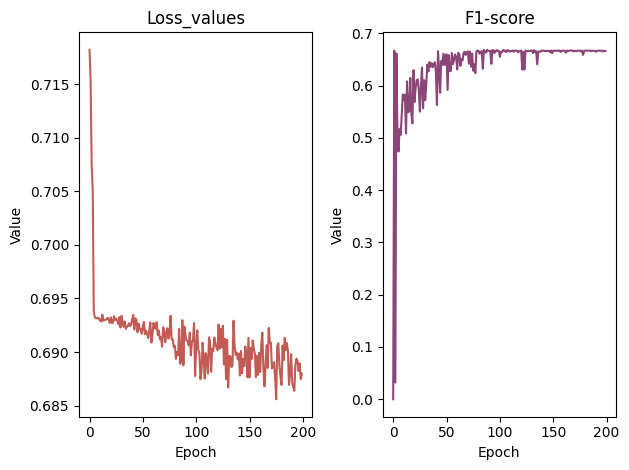

In [132]:
plt.subplot(1, 2, 1)
plt.plot(loss_values, color='#c25b53')
plt.title('Loss_values')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(f1_values, color='#8c4577')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

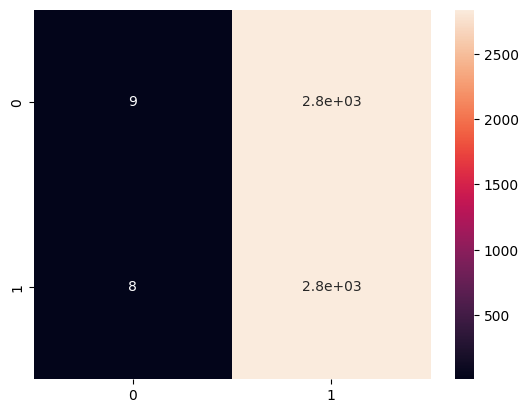

array([[   9, 2838],
       [   8, 2839]])

In [134]:
matrix = compute_conf_matrix(positive_prob_GD, negative_prob_GD)
sns.heatmap(matrix, annot=True)
plt.show()
matrix

TP = 9: истинно положительных предсказаний.\
FP = 2838: ложно позитивных предсказаний.\
FN = 8: ложно негативных предсказаний.\
TN = 2839: истинно позитивных предсказаний.

Высокое количество FP: Модель ошибочно классифицирует много отрицательных примеров как положительные\
Высокое количество TN: Модель правильно классифицирует большинство отрицательных примеров\
Низкое количество TP: Модель не может прежсказывать положительные примеры\
Низкое FN: Модель практически не ошибается, классифицируя положительные примеры как отрицательные, и наоборот.

### 9.2.1 Кросс-валидация

In [136]:
kf = KFold(n_splits=5)
loss_values, f1_values = [], []
accuracies, f1_scores, auc_scores = [], [], []
start_time = time.time()

for fold, (train_index, val_index) in enumerate(kf.split(train_g.ndata["products"])):
    print(f"Fold {fold+1}")

    # Создание тренировочных и валидационных наборов данных
    train_subset = train_index
    val_subset = val_index

    # Обучение модели
    model = GCN(train_g.ndata["products"].shape[1], 128, 2).double()
    predictor1 = DotPredictor()
    optimizer = torch.optim.SGD(
        itertools.chain(model.parameters(), predictor1.parameters()), lr=0.01
    )

    for i in range(100):
        model.train()
        h1 = model(train_g, train_g.ndata["products"])
        positive_score = predictor1(train_pos_g, h1)
        negative_score = predictor1(train_negative_g, h1)
        loss = compute_loss(positive_score, negative_score)
        accuracy = round(compute_accuracy(positive_score, negative_score), 5)
        f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"In epoch {i}, Loss: {round(loss.item(), 5)}, Accuracy: {accuracy}")

    model.eval()
    with torch.no_grad():
        h1 = model(train_g, train_g.ndata["products"])
        positive_score_GD = predictor1(test_pos_g, h1)
        negative_score_GD = predictor1(test_negative_g, h1)
        positive_prob_GD = torch.sigmoid(positive_score_GD)
        negative_prob_GD = torch.sigmoid(negative_score_GD)

        accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
        f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
        auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)

        accuracies.append(accurary)
        f1_scores.append(f1)
        auc_scores.append(auc_)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Average Accuracy: {sum(accuracies) / len(accuracies):.5f}")
print(f"Average F1_score: {sum(f1_scores) / len(f1_scores):.5f}")
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.5f}")
print(f"Elapsed Time: {elapsed_time:.5f}")

Fold 1
In epoch 0, Loss: 0.71141, Accuracy: 0.47996
In epoch 10, Loss: 0.69369, Accuracy: 0.49883
In epoch 20, Loss: 0.69352, Accuracy: 0.49895
In epoch 30, Loss: 0.69332, Accuracy: 0.49902
In epoch 40, Loss: 0.6933, Accuracy: 0.49918
In epoch 50, Loss: 0.69346, Accuracy: 0.49879
In epoch 60, Loss: 0.69335, Accuracy: 0.49904
In epoch 70, Loss: 0.69339, Accuracy: 0.49918
In epoch 80, Loss: 0.69347, Accuracy: 0.49897
In epoch 90, Loss: 0.69368, Accuracy: 0.499
Fold 2
In epoch 0, Loss: 0.69401, Accuracy: 0.49803
In epoch 10, Loss: 0.69387, Accuracy: 0.49828
In epoch 20, Loss: 0.69374, Accuracy: 0.49824
In epoch 30, Loss: 0.69375, Accuracy: 0.49819
In epoch 40, Loss: 0.69353, Accuracy: 0.49897
In epoch 50, Loss: 0.69354, Accuracy: 0.49854
In epoch 60, Loss: 0.69335, Accuracy: 0.49877
In epoch 70, Loss: 0.69359, Accuracy: 0.49854
In epoch 80, Loss: 0.69371, Accuracy: 0.49858
In epoch 90, Loss: 0.69346, Accuracy: 0.49885
Fold 3
In epoch 0, Loss: 0.69754, Accuracy: 0.49571
In epoch 10, Loss: 

Потери стабилизируются около 0.693, что очень близко к значению для случайного угадывания в бинарной классификации

Точность в каждой эпохе и каждом фолде стабилизируется около 0.499-0.4995, что указывает на случайное угадывание.
Средняя точность по всем фолдам равна 0.50000, что является показателем случайного угадывания в бинарной классификации.

Средний F1-Score очень низкий — 0.2013. Это говорит о том, что модель плохо различает классы и не умеет правильно предсказывать положительные и отрицательные классы.

Средний AUC равен 0.25039, что значительно ниже 0.5 и указывает на плохое качество классификации. AUC ниже 0.5 означает, что модель хуже, чем случайное угадывание.

## 9.3 GraphConv_x3 (3 слоя)

In [140]:
class GCN(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(n_input, n_hidden, allow_zero_in_degree=True)
        self.conv2 = GraphConv(n_hidden, n_hidden, allow_zero_in_degree=True)
        self.conv3 = GraphConv(n_hidden, n_output, allow_zero_in_degree=True)
        self.dropout = dropout
        self.batch_norm1 = nn.BatchNorm1d(n_hidden)
        self.batch_norm2 = nn.BatchNorm1d(n_hidden)

    def forward(self, g, in_features):
        out = F.elu(self.batch_norm1(self.conv1(g, in_features)))
        out = F.dropout(out, self.dropout, training=self.training)
        out = F.elu(self.batch_norm2(self.conv2(g, out)))
        out = F.dropout(out, self.dropout, training=self.training)
        out = self.conv3(g, out)
        return out

In [143]:
model = GCN(train_g.ndata["products"].shape[1], 128, 2)
model = model.double()
predictor1 = DotPredictor()
optimizer = torch.optim.SGD(
    itertools.chain(model.parameters(), predictor1.parameters()), lr=0.01
)

loss_values, f1_values = [], []
start_time = time.time()
for i in range(100):
    h1 = model(train_g, train_g.ndata["products"])
    positive_score = predictor1(train_pos_g, h1)
    negative_score = predictor1(train_negative_g, h1)
    loss = compute_loss(positive_score, negative_score)
    accuracy = round(compute_accuracy(positive_score, negative_score), 5)
    f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())
    loss = round(loss.item(), 5)
    f1_values.append(f1_sc)

    if i % 10 == 0:
        print(f"In epoch {i}, Loss: {loss}, Accuracy: {accuracy}")
end_time = time.time()
elapsed_time = end_time - start_time


with torch.no_grad():
    positive_score_GD = predictor1(test_pos_g, h1)
    negative_score_GD = predictor1(test_negative_g, h1)
    positive_prob_GD = torch.sigmoid(positive_score_GD)
    negative_prob_GD = torch.sigmoid(negative_score_GD)

def metrics():
  accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
  f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
  auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)
  t = round(elapsed_time, 5)
  return accurary, f1, auc_, t

accurary3, f13, auc_3, t3 = metrics()
print ('Accuracy = :', accurary3)
print ('F1_score = :', f13)
print ('Auc = :', auc_3)
print('Time =', t3)

In epoch 0, Loss: 0.73186, Accuracy: 0.46134
In epoch 10, Loss: 0.69361, Accuracy: 0.49842
In epoch 20, Loss: 0.6935, Accuracy: 0.49861
In epoch 30, Loss: 0.69342, Accuracy: 0.49852
In epoch 40, Loss: 0.69351, Accuracy: 0.49858
In epoch 50, Loss: 0.69345, Accuracy: 0.49836
In epoch 60, Loss: 0.69367, Accuracy: 0.4983
In epoch 70, Loss: 0.69368, Accuracy: 0.49887
In epoch 80, Loss: 0.69353, Accuracy: 0.49881
In epoch 90, Loss: 0.69335, Accuracy: 0.49902
Accuracy = : 0.4986
F1_score = : 0.42458
Auc = : 0.43582
Time = 42.40587


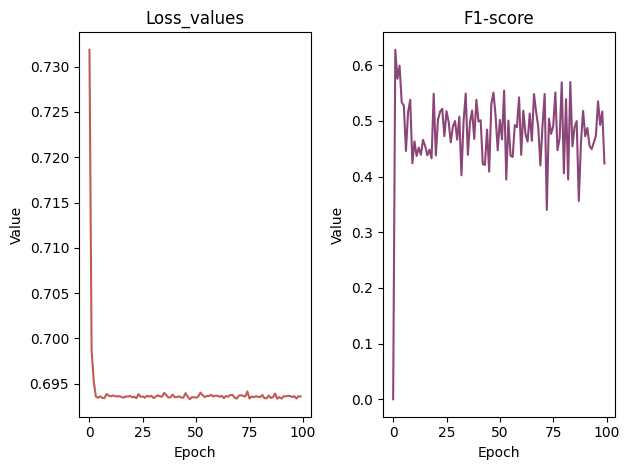

In [144]:
plt.subplot(1, 2, 1)
plt.plot(loss_values, color='#c25b53')
plt.title('Loss_values')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(f1_values, color='#8c4577')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

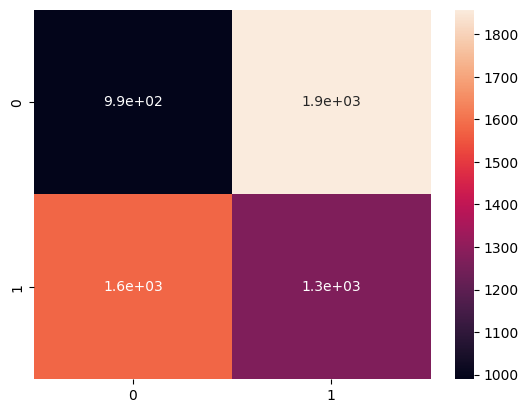

array([[ 989, 1858],
       [1579, 1268]])

In [145]:
matrix = compute_conf_matrix(positive_prob_GD, negative_prob_GD)
sns.heatmap(matrix, annot=True)
plt.show()
matrix

TP = 989: истинно позитивных предсказаний
FP = 1858: ложно позитивных предсказаний.\
FN = 1579: ложно негативных предсказаний.\
TP = 1268: истинно негативных предсказаний.

Высокое количество FP и FN: Модель ошибочно классифицирует много отрицательных примеров как положительные и наоборот\
Высокое количество TN: Модель правильно классифицирует достаточно много отрицательных примеров\
Низкое количество TP: Модель плохо предсказывает положительные примеры

### 9.3.1 Кросс-валидация

In [146]:
kf = KFold(n_splits=5)
loss_values, f1_values = [], []
accuracies, f1_scores, auc_scores = [], [], []
start_time = time.time()

for fold, (train_index, val_index) in enumerate(kf.split(train_g.ndata["products"])):
    print(f"Fold {fold+1}")

    # Создание тренировочных и валидационных наборов данных
    train_subset = train_index
    val_subset = val_index

    # Обучение модели
    model = GCN(train_g.ndata["products"].shape[1], 128, 2).double()
    predictor1 = DotPredictor()
    optimizer = torch.optim.SGD(
        itertools.chain(model.parameters(), predictor1.parameters()), lr=0.01
    )

    for i in range(100):
        model.train()
        h1 = model(train_g, train_g.ndata["products"])
        positive_score = predictor1(train_pos_g, h1)
        negative_score = predictor1(train_negative_g, h1)
        loss = compute_loss(positive_score, negative_score)
        accuracy = round(compute_accuracy(positive_score, negative_score), 5)
        f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"In epoch {i}, Loss: {round(loss.item(), 5)}, Accuracy: {accuracy}")

    model.eval()
    with torch.no_grad():
        h1 = model(train_g, train_g.ndata["products"])
        positive_score_GD = predictor1(test_pos_g, h1)
        negative_score_GD = predictor1(test_negative_g, h1)
        positive_prob_GD = torch.sigmoid(positive_score_GD)
        negative_prob_GD = torch.sigmoid(negative_score_GD)

        accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
        f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
        auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)

        accuracies.append(accurary)
        f1_scores.append(f1)
        auc_scores.append(auc_)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Average Accuracy: {sum(accuracies) / len(accuracies):.5f}")
print(f"Average F1_score: {sum(f1_scores) / len(f1_scores):.5f}")
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.5f}")
print(f"Elapsed Time: {elapsed_time:.5f}")

Fold 1
In epoch 0, Loss: 0.71907, Accuracy: 0.47214
In epoch 10, Loss: 0.69375, Accuracy: 0.49774
In epoch 20, Loss: 0.69389, Accuracy: 0.49776
In epoch 30, Loss: 0.69354, Accuracy: 0.49813
In epoch 40, Loss: 0.69378, Accuracy: 0.49811
In epoch 50, Loss: 0.6938, Accuracy: 0.49805
In epoch 60, Loss: 0.69358, Accuracy: 0.49764
In epoch 70, Loss: 0.6938, Accuracy: 0.49817
In epoch 80, Loss: 0.69379, Accuracy: 0.49819
In epoch 90, Loss: 0.69358, Accuracy: 0.49832
Fold 2
In epoch 0, Loss: 0.70417, Accuracy: 0.48652
In epoch 10, Loss: 0.69388, Accuracy: 0.49762
In epoch 20, Loss: 0.6939, Accuracy: 0.49727
In epoch 30, Loss: 0.69373, Accuracy: 0.49791
In epoch 40, Loss: 0.69385, Accuracy: 0.49801
In epoch 50, Loss: 0.69401, Accuracy: 0.49717
In epoch 60, Loss: 0.69352, Accuracy: 0.49776
In epoch 70, Loss: 0.69405, Accuracy: 0.49754
In epoch 80, Loss: 0.69389, Accuracy: 0.49756
In epoch 90, Loss: 0.69394, Accuracy: 0.4977
Fold 3
In epoch 0, Loss: 0.71566, Accuracy: 0.47543
In epoch 10, Loss: 0

Точность (Accuracy):

Accuracy = 0.50000 показывает, что модель правильно классифицирует примерно половину примеров. Это не лучше случайного угадывания для задачи бинарной классификации.

F1-score значение 0.64428 указывает на более высокую производительность по сравнению с точностью, особенно учитывая сбалансированный вклад точности и полноты. F1-score выше, чем точность, может указывать на то, что модель лучше работает с одним из классов.

AUC значение 0.53093 немного выше 0.5, что указывает на чуть лучшую производительность, чем случайное угадывание.

## 9.4 SAGEConv (собственный)

In [155]:
class SAGEConv(nn.Module):
    def __init__(self, in_feat, out_feat, dropout=0.2):
        super(SAGEConv, self).__init__()
        self.linear = nn.Linear(in_feat * 2, out_feat)
        self.batchnorm = nn.BatchNorm1d(out_feat)
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            g.update_all(
                message_func=fn.copy_u("h", "m"),
                reduce_func=fn.mean("m", "h_N"),
            )
            h_N = g.ndata["h_N"]
            h_total = torch.cat([h, h_N], dim=1)
            h_total = self.linear(h_total)
            h_total = self.batchnorm(h_total)
            h_total = self.dropout(h_total)
            return h_total

class Model(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Model, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats)
        self.conv2 = SAGEConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [156]:
model = Model(train_g.ndata["products"].shape[1], 128, 2)
model = model.double()
predictor1 = DotPredictor()
optimizer = torch.optim.SGD(
    itertools.chain(model.parameters(), predictor1.parameters()), lr=0.001
)

loss_values, f1_values = [], []
start_time = time.time()
for i in range(150):
    h1 = model(train_g, train_g.ndata["products"])
    positive_score = predictor1(train_pos_g, h1)
    negative_score = predictor1(train_negative_g, h1)
    loss = compute_loss(positive_score, negative_score)
    accuracy = round(compute_accuracy(positive_score, negative_score), 5)
    f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())
    loss = round(loss.item(), 5)
    f1_values.append(f1_sc)

    if i % 10 == 0:
        print(f"In epoch {i}, Loss: {loss}, Accuracy: {accuracy}")
end_time = time.time()
elapsed_time = end_time - start_time


with torch.no_grad():
    positive_score_GD = predictor1(test_pos_g, h1)
    negative_score_GD = predictor1(test_negative_g, h1)
    positive_prob_GD = torch.sigmoid(positive_score_GD)
    negative_prob_GD = torch.sigmoid(negative_score_GD)

def metrics():
  accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
  f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
  auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)
  t = round(elapsed_time, 5)
  return accurary, f1, auc_, t

accurary4, f14, auc_4, t4 = metrics()
print ('Accuracy = :', accurary4)
print ('F1_score = :', f14)
print ('Auc = :', auc_4)
print('Time =', t4)

In epoch 0, Loss: 0.77472, Accuracy: 0.57616
In epoch 10, Loss: 0.70244, Accuracy: 0.64584
In epoch 20, Loss: 0.68393, Accuracy: 0.65538
In epoch 30, Loss: 0.67445, Accuracy: 0.65659
In epoch 40, Loss: 0.66423, Accuracy: 0.65044
In epoch 50, Loss: 0.6317, Accuracy: 0.69443
In epoch 60, Loss: 0.64929, Accuracy: 0.66908
In epoch 70, Loss: 0.65733, Accuracy: 0.66254
In epoch 80, Loss: 0.61615, Accuracy: 0.71154
In epoch 90, Loss: 0.61234, Accuracy: 0.70608
In epoch 100, Loss: 0.62857, Accuracy: 0.6826
In epoch 110, Loss: 0.60246, Accuracy: 0.72565
In epoch 120, Loss: 0.65471, Accuracy: 0.64264
In epoch 130, Loss: 0.59364, Accuracy: 0.73228
In epoch 140, Loss: 0.59687, Accuracy: 0.71632
Accuracy = : 0.71531
F1_score = : 0.70117
Auc = : 0.79646
Time = 116.90977


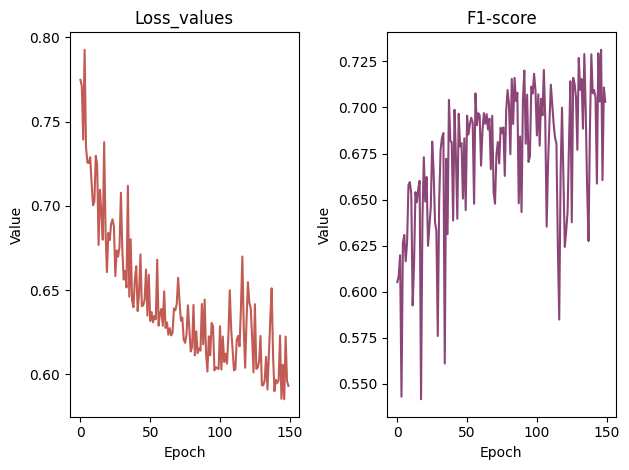

In [157]:
plt.subplot(1, 2, 1)
plt.plot(loss_values, color='#c25b53')
plt.title('Loss_values')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(f1_values, color='#8c4577')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

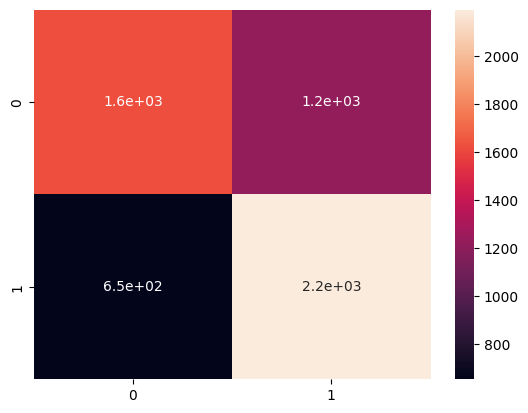

array([[1628, 1219],
       [ 652, 2195]])

In [158]:
matrix = compute_conf_matrix(positive_prob_GD, negative_prob_GD)
sns.heatmap(matrix, annot=True)
plt.show()
matrix

TP = 1628: истинно позитивных предсказаний\
FP = 1219: ложно позитивных предсказаний.\
FN = 652: ложно негативных предсказаний.\
TN = 2195: истинно негативных предсказаний.

Высокое количество TP и TN: Модель правильно классифицирует много положительных и отрицательных примеров (однако отрицательные примерны классифицирует лучше)\
Высокое количество FP: Модель ошибочно классифицирует много отрицательных примеров как положительные\
Низкое количество FN: Модель правильно классифицирует отрицательные примеры.

### 9.4.1 Кросс-валидация

In [160]:
kf = KFold(n_splits=5)
loss_values, f1_values = [], []
accuracies, f1_scores, auc_scores = [], [], []
start_time = time.time()

for fold, (train_index, val_index) in enumerate(kf.split(train_g.ndata["products"])):
    print(f"Fold {fold+1}")

    # Создание тренировочных и валидационных наборов данных
    train_subset = train_index
    val_subset = val_index

    # Обучение модели
    model = Model(train_g.ndata["products"].shape[1], 128, 2).double()
    predictor1 = DotPredictor()
    optimizer = torch.optim.SGD(
        itertools.chain(model.parameters(), predictor1.parameters()), lr=0.001
    )

    for i in range(100):
        model.train()
        h1 = model(train_g, train_g.ndata["products"])
        positive_score = predictor1(train_pos_g, h1)
        negative_score = predictor1(train_negative_g, h1)
        loss = compute_loss(positive_score, negative_score)
        accuracy = round(compute_accuracy(positive_score, negative_score), 5)
        f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"In epoch {i}, Loss: {round(loss.item(), 5)}, Accuracy: {accuracy}")

    model.eval()
    with torch.no_grad():
        h1 = model(train_g, train_g.ndata["products"])
        positive_score_GD = predictor1(test_pos_g, h1)
        negative_score_GD = predictor1(test_negative_g, h1)
        positive_prob_GD = torch.sigmoid(positive_score_GD)
        negative_prob_GD = torch.sigmoid(negative_score_GD)

        accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
        f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
        auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)

        accuracies.append(accurary)
        f1_scores.append(f1)
        auc_scores.append(auc_)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Average Accuracy: {sum(accuracies) / len(accuracies):.5f}")
print(f"Average F1_score: {sum(f1_scores) / len(f1_scores):.5f}")
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.5f}")
print(f"Elapsed Time: {elapsed_time:.5f}")

Fold 1
In epoch 0, Loss: 0.92284, Accuracy: 0.5383
In epoch 10, Loss: 0.71634, Accuracy: 0.6425
In epoch 20, Loss: 0.67725, Accuracy: 0.66366
In epoch 30, Loss: 0.66736, Accuracy: 0.66584
In epoch 40, Loss: 0.65769, Accuracy: 0.66475
In epoch 50, Loss: 0.64713, Accuracy: 0.66539
In epoch 60, Loss: 0.64166, Accuracy: 0.67536
In epoch 70, Loss: 0.61544, Accuracy: 0.7012
In epoch 80, Loss: 0.62187, Accuracy: 0.69023
In epoch 90, Loss: 0.61691, Accuracy: 0.68906
Fold 2
In epoch 0, Loss: 0.88398, Accuracy: 0.54072
In epoch 10, Loss: 0.71425, Accuracy: 0.62791
In epoch 20, Loss: 0.67079, Accuracy: 0.68266
In epoch 30, Loss: 0.69135, Accuracy: 0.61889
In epoch 40, Loss: 0.68767, Accuracy: 0.63423
In epoch 50, Loss: 0.67814, Accuracy: 0.62818
In epoch 60, Loss: 0.6496, Accuracy: 0.67632
In epoch 70, Loss: 0.64207, Accuracy: 0.66367
In epoch 80, Loss: 0.6389, Accuracy: 0.69025
In epoch 90, Loss: 0.61999, Accuracy: 0.69532
Fold 3
In epoch 0, Loss: 0.87938, Accuracy: 0.53231
In epoch 10, Loss: 0.

Accuracy = 0.78585 показывает, что модель правильно классифицирует примерно 79% примеров.

F1-score значение 0.7638, что значит, что модель достаточно хорошо сбалансирована между точностью и полнотой

AUC значение 0.87196 указывает на хорошую способность модели различать классы

## 9.5 WeightedSAGEConv (собственный)

In [161]:
class WeightedSAGEConv(nn.Module):
    def __init__(self, in_feat, out_feat, dropout=0.5):
        super(WeightedSAGEConv, self).__init__()
        self.linear = nn.Linear(in_feat * 2, out_feat)
        self.batchnorm = nn.BatchNorm1d(out_feat)
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, h, w):
        with g.local_scope():
            g.ndata["h"] = h
            g.edata["w"] = w
            g.update_all(
                message_func=fn.u_mul_e("h", "w", "m"),
                reduce_func=fn.mean("m", "h_N"),
            )
            h_N = g.ndata["h_N"]
            h_total = torch.cat([h, h_N], dim=1)
            h_total = self.linear(h_total)
            h_total = self.batchnorm(h_total)
            h_total = self.dropout(h_total)
            return h_total

class Model(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Model, self).__init__()
        self.conv1 = WeightedSAGEConv(in_feats, h_feats)
        self.conv2 = WeightedSAGEConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        edge_weights = torch.ones(g.num_edges(), 1, dtype=in_feat.dtype)
        h = self.conv1(g, in_feat, edge_weights)
        h = F.relu(h)
        h = self.conv2(g, h, edge_weights)
        return h

In [164]:
model = Model(train_g.ndata["products"].shape[1], 128, 2)
model = model.double()
predictor1 = DotPredictor()
optimizer = torch.optim.SGD(
    itertools.chain(model.parameters(), predictor1.parameters()), lr=0.01
)

loss_values, f1_values = [], []
start_time = time.time()
for i in range(150):
    h1 = model(train_g, train_g.ndata["products"])
    positive_score = predictor1(train_pos_g, h1)
    negative_score = predictor1(train_negative_g, h1)
    loss = compute_loss(positive_score, negative_score)
    accuracy = round(compute_accuracy(positive_score, negative_score), 5)
    f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())
    loss = round(loss.item(), 5)
    f1_values.append(f1_sc)

    if i % 10 == 0:
        print(f"In epoch {i}, Loss: {loss}, Accuracy: {accuracy}")
end_time = time.time()
elapsed_time = end_time - start_time


with torch.no_grad():
    positive_score_GD = predictor1(test_pos_g, h1)
    negative_score_GD = predictor1(test_negative_g, h1)
    positive_prob_GD = torch.sigmoid(positive_score_GD)
    negative_prob_GD = torch.sigmoid(negative_score_GD)

def metrics():
  accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
  f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
  auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)
  t = round(elapsed_time, 5)
  return accurary, f1, auc_, t

accurary5, f15, auc_5, t5 = metrics()
print ('Accuracy = :', accurary5)
print ('F1_score = :', f15)
print ('Auc = :', auc_5)
print('Time =', t5)

In epoch 0, Loss: 0.9759, Accuracy: 0.52829
In epoch 10, Loss: 0.75855, Accuracy: 0.53212
In epoch 20, Loss: 0.71025, Accuracy: 0.59263
In epoch 30, Loss: 0.74526, Accuracy: 0.52533
In epoch 40, Loss: 0.70636, Accuracy: 0.57325
In epoch 50, Loss: 0.67727, Accuracy: 0.59583
In epoch 60, Loss: 0.69745, Accuracy: 0.57669
In epoch 70, Loss: 0.72876, Accuracy: 0.53368
In epoch 80, Loss: 0.65385, Accuracy: 0.62861
In epoch 90, Loss: 0.72149, Accuracy: 0.52687
In epoch 100, Loss: 0.65343, Accuracy: 0.63751
In epoch 110, Loss: 0.65852, Accuracy: 0.59345
In epoch 120, Loss: 0.68038, Accuracy: 0.56833
In epoch 130, Loss: 0.6397, Accuracy: 0.6283
In epoch 140, Loss: 0.69028, Accuracy: 0.54607
Accuracy = : 0.60379
F1_score = : 0.46861
Auc = : 0.63635
Time = 131.98102


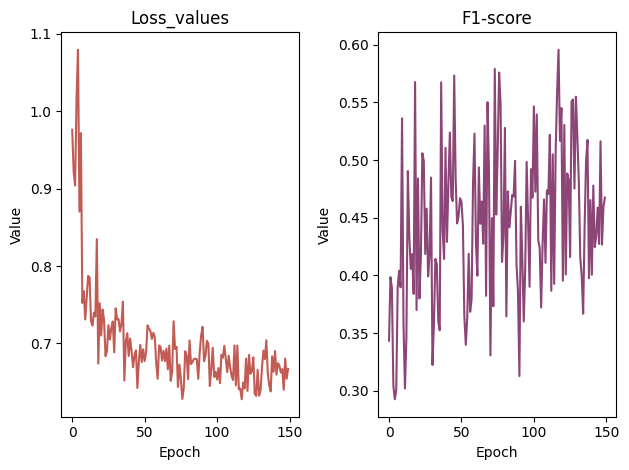

In [165]:
plt.subplot(1, 2, 1)
plt.plot(loss_values, color='#c25b53')
plt.title('Loss_values')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(f1_values, color='#8c4577')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

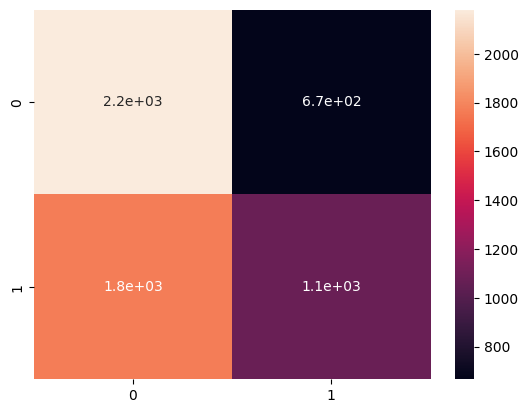

array([[2181,  666],
       [1772, 1075]])

In [166]:
matrix = compute_conf_matrix(positive_prob_GD, negative_prob_GD)
sns.heatmap(matrix, annot=True)
plt.show()
matrix

TP = 2181: истинно позитивных предсказаний\
FP = 666: ложно позитивных предсказаний.\
FN = 1772: ложно негативных предсказаний.\
TN = 1075: истинно негативных предсказаний.

Высокое количество TP: Модель правильно классифицирует много положительных примеров\
Умеренное количество TN: Модель нормально классифицирует отрицательные примеры\
Высокое количество FN: Модель ошибочно классифицирует много положительных примеров как отрицательные\
Низкое количество FP: Модель мало ошибается, классифицируя негативные примеры как позитивные.

### 9.5.1 Кросс-валидация

In [167]:
kf = KFold(n_splits=5)
loss_values, f1_values = [], []
accuracies, f1_scores, auc_scores = [], [], []
start_time = time.time()

for fold, (train_index, val_index) in enumerate(kf.split(train_g.ndata["products"])):
    print(f"Fold {fold+1}")

    # Создание тренировочных и валидационных наборов данных
    train_subset = train_index
    val_subset = val_index

    # Обучение модели
    model = Model(train_g.ndata["products"].shape[1], 128, 2).double()
    predictor1 = DotPredictor()
    optimizer = torch.optim.SGD(
        itertools.chain(model.parameters(), predictor1.parameters()), lr=0.01
    )

    for i in range(100):
        model.train()
        h1 = model(train_g, train_g.ndata["products"])
        positive_score = predictor1(train_pos_g, h1)
        negative_score = predictor1(train_negative_g, h1)
        loss = compute_loss(positive_score, negative_score)
        accuracy = round(compute_accuracy(positive_score, negative_score), 5)
        f1_sc = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"In epoch {i}, Loss: {round(loss.item(), 5)}, Accuracy: {accuracy}")

    model.eval()
    with torch.no_grad():
        h1 = model(train_g, train_g.ndata["products"])
        positive_score_GD = predictor1(test_pos_g, h1)
        negative_score_GD = predictor1(test_negative_g, h1)
        positive_prob_GD = torch.sigmoid(positive_score_GD)
        negative_prob_GD = torch.sigmoid(negative_score_GD)

        accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 5)
        f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 5)
        auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 5)

        accuracies.append(accurary)
        f1_scores.append(f1)
        auc_scores.append(auc_)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Average Accuracy: {sum(accuracies) / len(accuracies):.5f}")
print(f"Average F1_score: {sum(f1_scores) / len(f1_scores):.5f}")
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.5f}")
print(f"Elapsed Time: {elapsed_time:.5f}")

Fold 1
In epoch 0, Loss: 0.95978, Accuracy: 0.5008
In epoch 10, Loss: 0.79002, Accuracy: 0.5769
In epoch 20, Loss: 0.74253, Accuracy: 0.59507
In epoch 30, Loss: 0.70453, Accuracy: 0.60676
In epoch 40, Loss: 0.70649, Accuracy: 0.58137
In epoch 50, Loss: 0.66563, Accuracy: 0.61954
In epoch 60, Loss: 0.65802, Accuracy: 0.62758
In epoch 70, Loss: 0.68038, Accuracy: 0.58482
In epoch 80, Loss: 0.67876, Accuracy: 0.60584
In epoch 90, Loss: 0.6454, Accuracy: 0.63234
Fold 2
In epoch 0, Loss: 1.1148, Accuracy: 0.48564
In epoch 10, Loss: 0.81117, Accuracy: 0.5313
In epoch 20, Loss: 0.73323, Accuracy: 0.57216
In epoch 30, Loss: 0.71712, Accuracy: 0.5867
In epoch 40, Loss: 0.71833, Accuracy: 0.55778
In epoch 50, Loss: 0.71091, Accuracy: 0.55846
In epoch 60, Loss: 0.66252, Accuracy: 0.61729
In epoch 70, Loss: 0.71834, Accuracy: 0.54072
In epoch 80, Loss: 0.68491, Accuracy: 0.57674
In epoch 90, Loss: 0.69281, Accuracy: 0.56677
Fold 3
In epoch 0, Loss: 0.92939, Accuracy: 0.50336
In epoch 10, Loss: 0.7

Accuracy = 0.74387 показывает, что модель правильно классифицирует примерно 74% примеров.

F1-score значение 0.75304, что значит, что модель достаточно хорошо сбалансирована между точностью и полнотой

AUC значение 0.87179 указывает на хорошую способность модели различать классы

# 10 Результаты

In [328]:
a = [accurary1, accurary2, accurary3, accurary4, accurary5]
f = [f11, f12, f13, f14, f15]
au = [auc_1, auc_2, auc_3, auc_4, auc_5]
t = [t1, t2, t3, t4, t5]
v_a = [0.73432, 0.50000, 0.50000, 0.78585, 0.74387]
v_f = [0.70258, 0.20130, 0.64428, 0.76380, 0.75304]
v_au = [0.80096, 0.25039, 0.53093, 0.87196, 0.87179]
v_t = [130.26522, 200.19973, 227.60497, 438.54439, 423.16836]
res_d = {'accurary': a, 'f1-score': f, 'AUC': au, 'time': t,
         'val_accuracy': v_a, 'val_f1-score': v_f, 'val_AUC': v_au, 'val_time': v_t}
index_values = ['GraphSAGE', 'GraphConv_x2', 'GraphConv_x3', 'SAGEConv', 'WeightedSAGEConv']
res_df = pd.DataFrame(res_d)
res_df = res_df.set_index(pd.Index(index_values))
res_df

,accurary,f1-score,AUC,time,val_accuracy,val_f1-score,val_AUC,val_time
GraphSAGE,0.81718,0.79104,0.90250,30.13461,0.73432,0.70258,0.80096,130.26522
GraphConv_x2,0.49491,0.66612,0.67490,70.32186,0.50000,0.20130,0.25039,200.19973
GraphConv_x3,0.49860,0.42458,0.43582,42.40587,0.50000,0.64428,0.53093,227.60497
SAGEConv,0.71531,0.70117,0.79646,116.90977,0.78585,0.76380,0.87196,438.54439
WeightedSAGEConv,0.60379,0.46861,0.63635,131.98102,0.74387,0.75304,0.87179,423.16836


In [329]:
res_df.sort_values('f1-score', ascending=False)

,accurary,f1-score,AUC,time,val_accuracy,val_f1-score,val_AUC,val_time
GraphSAGE,0.81718,0.79104,0.90250,30.13461,0.73432,0.70258,0.80096,130.26522
SAGEConv,0.71531,0.70117,0.79646,116.90977,0.78585,0.76380,0.87196,438.54439
GraphConv_x2,0.49491,0.66612,0.67490,70.32186,0.50000,0.20130,0.25039,200.19973
WeightedSAGEConv,0.60379,0.46861,0.63635,131.98102,0.74387,0.75304,0.87179,423.16836
GraphConv_x3,0.49860,0.42458,0.43582,42.40587,0.50000,0.64428,0.53093,227.60497


# 11. Рекомендации

Для получения рекомендаций использована модель GraphSAGE

In [582]:
df = pd.read_csv('all_data.csv')
d_nodes = pd.read_csv('/content/d_nodes.csv')
edges = pd.read_csv('/content/d_edges.csv')
df.head(1)

,ID,customer_name,customer_INN,order_price,provider_name,provider_INN,product
0,411631361384158,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.01,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Хлеб недлительного хранения '№ 32787 Хлебобуло...


In [583]:
# ИНН и их номер
all_inn = sorted(pd.concat([edges['customer_INN'], edges['provider_INN']]).unique().tolist())
counter = {val: i for i, val in enumerate(all_inn)}

## 11.1 Функции для получения значений вершин из словаря

In [584]:
def get_value_by_key(dictionary, keyy):
    for key, val in dictionary.items():
        if key == keyy:
            return val
    return None

def get_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None

## 11.2 Информация о заказчике

In [600]:
def info_customer():
  u_inns = sorted(df['customer_INN'].unique())
  random_index = random.randint(0, len(u_inns) - 1)
  selected_inn = u_inns[random_index]
  noda = get_value_by_key(counter, selected_inn)
  print('ИНФОРМАЦИЯ О ЗАКАЗЧИКЕ')
  print("ИНН случайно выбранного заказчика:", selected_inn)
  print("Наименование выбранного заказчика:", list(df[df['customer_INN']==selected_inn]['customer_name'])[0])
  print("Вершина в графе = ", noda)
  return noda

## 11.3 Поиск всех поставщиков из истории выполнения заказов

In [595]:
def get_from_history(noda):
  print('Поставщики, которые уже выполняли заказ выбранного заказчика:')
  all_providers = list(set(nodes[nodes['customer_INN'] == noda]['provider_INN']))
  u_inns_p = sorted(df['provider_INN'].unique())
  for p in all_providers:
    inn = get_key_by_value(counter, p)
    name = list(df[df['provider_INN'] == inn]['provider_name'])[0]
    print('ИНН поставщика:', inn)
    print(name)
    print('Вершина в графе =', p)
    print('')

## 11.4 Рекомендательная система

In [605]:
def rec_system(n:int):
  """
  n - количество необходимым рекомендаций
  """

  noda = info_customer()
  print('---------------------------------------------------------------------------------------------')
  get_from_history(noda)
  print('---------------------------------------------------------------------------------------------')

  all_nodes = g.nodes().shape[0]
  node_range = np.arange(all_nodes)

  #Исключение выбранного заказчика для создания нового графа g_without
  g_without = dgl.graph(
    (np.concatenate([node_range[:noda], node_range[noda + 1:]]),
     np.full(all_nodes - 1, noda)),
    num_nodes=all_nodes
    )

  # Получение эмбеддингов для нового графа.
  # Применение модели для получения вероятностей для всех возможных поставщиков
  with torch.no_grad():
    scores = predictor1(g_without, h1)
    probabilities = torch.sigmoid(scores)

  # Объединение вероятностей и ребер
  prob_edges = torch.cat(
      (g_without.edges()[0].unsqueeze(0), probabilities.unsqueeze(0)), dim=0).numpy()

  recommendations = (prob_edges[0, np.argsort(prob_edges[1])[::-1]])[:n]

  for elem in recommendations:
    elem = int(elem)
    inn = get_key_by_value(counter, elem)
    print(inn)
    print(list(df[df['provider_INN'] == inn]['provider_name'])[0])
    print('')
rec_system(n=5)

ИНФОРМАЦИЯ О ЗАКАЗЧИКЕ
ИНН случайно выбранного заказчика: 9703042554
Наименование выбранного заказчика: ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ГОРОДА МОСКВЫ "УПРАВЛЕНИЕ ОБЕСПЕЧЕНИЯ ДЕЯТЕЛЬНОСТИ КОМПЛЕКСА ГРАДОСТРОИТЕЛЬНОЙ ПОЛИТИКИ И СТРОИТЕЛЬСТВА ГОРОДА МОСКВЫ"
Вершина в графе =  3426
---------------------------------------------------------------------------------------------
Поставщики, которые уже выполняли заказ выбранного заказчика:
ИНН поставщика: 7701984274
АКЦИОНЕРНОЕ ОБЩЕСТВО "МОСВОДОКАНАЛ"
Вершина в графе = 2702

ИНН поставщика: 9204555053
ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "КАЯЛА"
Вершина в графе = 3409

ИНН поставщика: 771701571199
ГУСЕВ АЛЕКСЕЕВИЧ АНДРЕЙ
Вершина в графе = 3827

ИНН поставщика: 771907330711
СИМАКОВ СЕРГЕЕВИЧ ВАЛЕРИЙ
Вершина в графе = 3829

ИНН поставщика: 7751229277
ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "МАРКЕТСНАБ"
Вершина в графе = 3068

---------------------------------------------------------------------------------------------
2623802285
ОБЩЕСТВ

Из информации о прошлых поставщиках видно, что запросы на указания услуг связаны свкорее всего с энергоресурсами, водоснабжением и т.д.\
На выходе получены рекомендации о 5 поставщиках, которые брали похожие заказы